[FASE 0.0] Memuat dan Melakukan Overview Dataset Awal...

[INFO] Berhasil memuat file untuk overview: Data Pakai Label.csv

--- Informasi Dasar Dataset ---
Jumlah Baris (Sampel): 10798
Jumlah Kolom (Fitur): 9

Nama Kolom:
['userName', 'content', 'score', 'reviewCreatedVersion', 'at', 'Sentimen (Aurel)', 'Sentimen (Ade)', 'Sentimen (Eky)', 'Sentimen Akhir']

Beberapa Baris Pertama Data:
          userName                                            content  score  \
0    Made Darmawan  Saya kasi bintang 1 dulu ya. Tolong diperbaiki...      1   
1    windi tripani  Apknya memudahkan dalam perubahan data, ngecek...      5   
2       PURLAMBANG  Saya mau merubah data KIS saya di aplikasi jkn...      1   
3        Nanang WR  Faskes tidak bisa di search, dan yang ditampil...      1   
4  Oktriyani Putri  Kenapa ketika ingin masuk akun ada pendaftaran...      1   

  reviewCreatedVersion                   at  Sentimen (Aurel)  Sentimen (Ade)  \
0                4.3.0  2023-01-22 12:04:08      

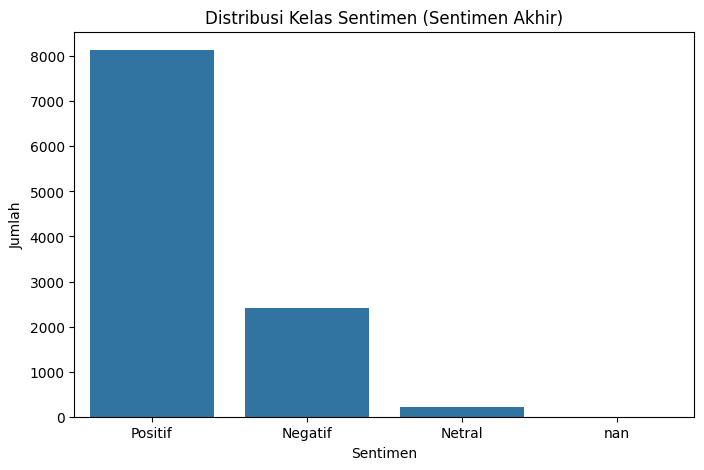


--- Informasi Kolom 'score' ---
Distribusi nilai 'score':
score
1    1707
2     299
3     314
4     733
5    7745
Name: count, dtype: int64


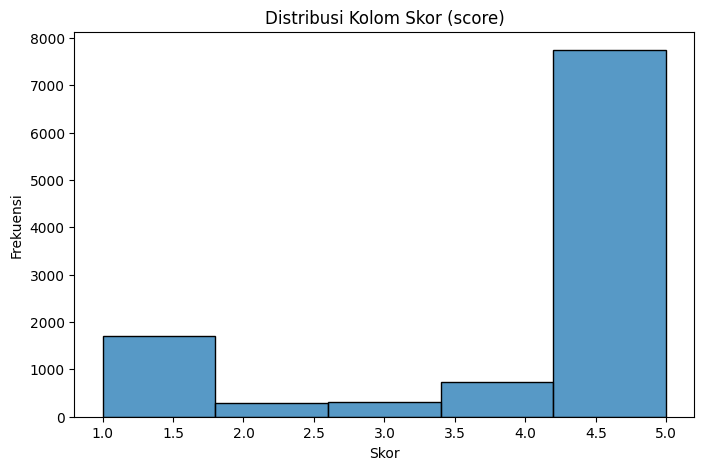


[FASE 0.0] Overview Dataset Awal Selesai dalam 0.40 detik.
----------------------------------------------------------------------


In [1]:
# --- Blok 0.0: Overview Informasi Dataset Awal ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
print("[FASE 0.0] Memuat dan Melakukan Overview Dataset Awal...")
start_fase0_0_time = time.time() # Pastikan 'import time' sudah ada jika ini sel pertama

# --- Pemuatan Data Awal (Hanya untuk Overview) ---
csv_file_path = 'Data Pakai Label.csv' # Nama file CSV asli Anda

try:
    df_overview = pd.read_csv(csv_file_path)
    print(f"\n[INFO] Berhasil memuat file untuk overview: {csv_file_path}")
except FileNotFoundError:
    print(f"[ERROR] File '{csv_file_path}' tidak ditemukan. Pastikan path file benar.")
    exit()
except Exception as e:
    print(f"[ERROR] Terjadi kesalahan saat memuat data: {e}")
    exit()

# --- Informasi Dasar Dataset ---
print("\n--- Informasi Dasar Dataset ---")
print(f"Jumlah Baris (Sampel): {df_overview.shape[0]}")
print(f"Jumlah Kolom (Fitur): {df_overview.shape[1]}")

print("\nNama Kolom:")
print(df_overview.columns.tolist())

print("\nBeberapa Baris Pertama Data:")
print(df_overview.head())

print("\nInfo Tipe Data dan Missing Values per Kolom:")
df_overview.info()

print("\nStatistik Deskriptif untuk Kolom Numerik (jika ada, misal 'score'):")
# Hanya tampilkan statistik untuk kolom yang benar-benar numerik
numeric_cols = df_overview.select_dtypes(include=['number']).columns
if not numeric_cols.empty:
    print(df_overview[numeric_cols].describe())
else:
    print("Tidak ada kolom numerik untuk statistik deskriptif.")

# --- Informasi Spesifik Kolom yang Relevan ---
content_col = 'content' # Kolom teks asli Bahasa Indonesia
sentiment_col_akhir = 'Sentimen Akhir' # Kolom sentimen target

if content_col in df_overview.columns:
    print(f"\n--- Informasi Kolom Teks Asli ('{content_col}') ---")
    print(f"Jumlah nilai unik: {df_overview[content_col].nunique()}")
    print(f"Jumlah nilai kosong (NaN): {df_overview[content_col].isnull().sum()}")
    # Contoh teks
    if not df_overview[content_col].isnull().all(): # Cek jika tidak semua NaN
        print("\nContoh beberapa teks:")
        print(df_overview[content_col].dropna().sample(min(5, len(df_overview[content_col].dropna()))).values) # Ambil sampel 5 teks non-NaN
else:
    print(f"[PERINGATAN] Kolom '{content_col}' tidak ditemukan.")


if sentiment_col_akhir in df_overview.columns:
    print(f"\n--- Informasi Kolom Target ('{sentiment_col_akhir}') ---")
    print(f"Distribusi Kelas Sentimen ('{sentiment_col_akhir}'):")
    sentiment_counts = df_overview[sentiment_col_akhir].value_counts(dropna=False) # dropna=False untuk melihat NaN juga
    print(sentiment_counts)
    print(f"\nJumlah nilai kosong (NaN) di '{sentiment_col_akhir}': {df_overview[sentiment_col_akhir].isnull().sum()}")

    # Visualisasi Distribusi Kelas Sentimen
    if not sentiment_counts.empty:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df_overview, x=sentiment_col_akhir, order=sentiment_counts.index)
        plt.title(f'Distribusi Kelas Sentimen ({sentiment_col_akhir})')
        plt.xlabel('Sentimen')
        plt.ylabel('Jumlah')
        plt.show()
else:
    print(f"[PERINGATAN] Kolom '{sentiment_col_akhir}' tidak ditemukan.")


# Informasi tentang kolom skor (jika relevan untuk dipahami distribusinya)
score_col = 'score'
if score_col in df_overview.columns and pd.api.types.is_numeric_dtype(df_overview[score_col]):
    print(f"\n--- Informasi Kolom '{score_col}' ---")
    print(f"Distribusi nilai '{score_col}':")
    print(df_overview[score_col].value_counts(dropna=False).sort_index())
    
    plt.figure(figsize=(8, 5))
    sns.histplot(df_overview[score_col], kde=False, bins=df_overview[score_col].nunique()) # bins disesuaikan dengan jumlah nilai unik
    plt.title(f'Distribusi Kolom Skor ({score_col})')
    plt.xlabel('Skor')
    plt.ylabel('Frekuensi')
    plt.show()
elif score_col in df_overview.columns:
    print(f"\n[PERINGATAN] Kolom '{score_col}' ditemukan tetapi bukan tipe numerik. Distribusi tidak divisualisasikan.")
else:
    print(f"[INFO] Kolom '{score_col}' tidak ditemukan.")


end_fase0_0_time = time.time()
print(f"\n[FASE 0.0] Overview Dataset Awal Selesai dalam {end_fase0_0_time - start_fase0_0_time:.2f} detik.")
print("-" * 70)

In [2]:
# --- Blok 0: Inisialisasi, Fungsi Global, dan Pemuatan Data ---
import pandas as pd
import re
import string
import nltk
import ssl
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from afinn import Afinn
from textblob import TextBlob
from senticnet.senticnet import SenticNet # Pastikan senticnet terinstal
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os # Untuk memeriksa keberadaan file

# --- Konfigurasi dan Download Resource NLTK ---
def download_nltk_resources():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

    resources = {
        "punkt": "tokenizers/punkt",
        "stopwords": "corpora/stopwords",
        "averaged_perceptron_tagger": "taggers/averaged_perceptron_tagger",
        "wordnet": "corpora/wordnet",
        "omw-1.4": "corpora/omw-1.4",
        "sentiwordnet": "corpora/sentiwordnet"
    }
    
    for resource_name, resource_path in resources.items():
        try:
            nltk.data.find(resource_path)
            print(f"[INFO] NLTK resource '{resource_name}' ({resource_path}) sudah ada.")
        except LookupError:
            print(f"[INFO] NLTK resource '{resource_name}' ({resource_path}) tidak ditemukan. Mengunduh...")
            try:
                nltk.download(resource_name, quiet=True)
                print(f"[INFO] Berhasil mengunduh '{resource_name}'.")
            except Exception as e:
                print(f"[ERROR] Gagal mengunduh '{resource_name}': {e}")
                print(f"         Coba jalankan secara manual: nltk.download('{resource_name}')")
        except Exception as e:
            print(f"[ERROR] Error saat memeriksa resource {resource_name}: {e}")

download_nltk_resources()
print("-" * 50)

# Fungsi untuk memberi label sentimen berdasarkan skor
def label_sentiment(score, pos_thresh=0.05, neg_thresh=-0.05):
    if score > pos_thresh:
        return "Positif"
    elif score < neg_thresh:
        return "Negatif"
    else:
        return "Netral"

# --- Pemuatan Data dan Sampling ---
csv_file_path_original = 'Data Pakai Label.csv'
csv_file_path_sample_translated = 'Data_Sample_Translated.csv' # File untuk menyimpan/memuat sampel terjemahan
translated_column_name = 'translated_content'
sample_size = 10798
content_column_original = 'content' # Kolom teks asli Bahasa Indonesia

df_sampled_translated = None

# Coba muat sampel yang sudah ditranslasi jika ada
if os.path.exists(csv_file_path_sample_translated):
    try:
        df_sampled_translated = pd.read_csv(csv_file_path_sample_translated)
        if translated_column_name in df_sampled_translated.columns and len(df_sampled_translated) == sample_size:
            print(f"[INFO] Berhasil memuat sampel yang sudah ditranslasi dari: {csv_file_path_sample_translated}")
        else:
            print(f"[INFO] File sampel terjemahan ditemukan ({csv_file_path_sample_translated}) tetapi format/ukuran tidak sesuai. Akan dibuat ulang.")
            df_sampled_translated = None # Reset agar dibuat ulang
    except Exception as e:
        print(f"[PERINGATAN] Gagal memuat file sampel terjemahan ({csv_file_path_sample_translated}): {e}. Akan dibuat ulang.")
        df_sampled_translated = None

if df_sampled_translated is None:
    try:
        df_full = pd.read_csv(csv_file_path_original)
        print(f"[INFO] Berhasil memuat file asli: {csv_file_path_original}")
        print(f"Jumlah baris awal (keseluruhan): {len(df_full)}")

        if content_column_original not in df_full.columns:
            print(f"[ERROR] Kolom '{content_column_original}' tidak ditemukan di {csv_file_path_original}.")
            exit()

        # --- SAMPLING DATA ---
        if len(df_full) > sample_size:
            print(f"[INFO] Melakukan sampling sebanyak {sample_size} baris dari dataset asli.")
            df_to_process = df_full.sample(n=sample_size, random_state=42).reset_index(drop=True)
        else:
            print(f"[INFO] Ukuran dataset ({len(df_full)}) <= sample_size ({sample_size}). Menggunakan seluruh dataset.")
            df_to_process = df_full.copy()
        
        print(f"Jumlah baris untuk diproses/translasi: {len(df_to_process)}")

        # --- FASE 0 (OPSIONAL): Translasi Teks dari Bahasa Indonesia ke Bahasa Inggris ---
        # Jika Anda ingin melakukan translasi otomatis PADA SAMPEL, uncomment bagian di bawah.
        # Pastikan Anda sudah `pip install transformers sentencepiece sacremoses`
        
        from transformers import MarianMTModel, MarianTokenizer
        model_name_translation = "Helsinki-NLP/opus-mt-id-en"

        def translate_batch_hf(texts_series, model_name="Helsinki-NLP/opus-mt-id-en", batch_size=8):
            print(f"[INFO] Memuat model translasi: {model_name}")
            tokenizer = MarianTokenizer.from_pretrained(model_name)
            model = MarianMTModel.from_pretrained(model_name)
            print("[INFO] Model translasi dimuat.")
            
            texts = texts_series.tolist()
            translated_texts = []
            num_batches = (len(texts) + batch_size - 1) // batch_size
            
            for i in range(num_batches):
                start_idx = i * batch_size
                end_idx = min((i + 1) * batch_size, len(texts))
                batch_texts_cleaned = [str(text) if pd.notnull(text) else "" for text in texts[start_idx:end_idx]]
                
                print(f"[INFO] Menerjemahkan batch {i+1}/{num_batches} (ukuran: {len(batch_texts_cleaned)})...")
                try:
                    inputs = tokenizer(batch_texts_cleaned, return_tensors="pt", padding=True, truncation=True, max_length=512)
                    translated_tokens = model.generate(**inputs)
                    batch_translated = [tokenizer.decode(t, skip_special_tokens=True) for t in translated_tokens]
                    translated_texts.extend(batch_translated)
                except Exception as e:
                    print(f"[ERROR] Gagal menerjemahkan batch {i+1}: {e}")
                    translated_texts.extend([""] * len(batch_texts_cleaned))
                time.sleep(0.1)
            return pd.Series(translated_texts, index=texts_series.index)

        # Lakukan translasi HANYA PADA SAMPEL
        print("[INFO] Memulai proses translasi untuk data sampel...")
        start_translate_time = time.time()
        df_to_process[translated_column_name] = translate_batch_hf(df_to_process[content_column_original])
        end_translate_time = time.time()
        print(f"[INFO] Proses translasi sampel selesai dalam {end_translate_time - start_translate_time:.2f} detik.")
        
        # *** BAGIAN INI YANG DITAMBAHKAN UNTUK KASUS TRANSLASI MANUAL ***
        # Jika Anda melakukan translasi manual, pastikan kolom hasil translasi sudah ada di `df_full`
        # dan skrip akan mengambilnya saat sampling.
        # Jika Anda uncomment blok translasi di atas, baris ini tidak akan dieksekusi
        # karena `translated_column_name` sudah dibuat.
        if translated_column_name not in df_to_process.columns:
            # Ini adalah placeholder jika translasi tidak dilakukan di skrip.
            # Idealnya, Anda sudah punya kolom ini di CSV asli jika translasi manual.
            print(f"[PERINGATAN] Kolom '{translated_column_name}' tidak ada. Akan dibuat placeholder dari '{content_column_original}'.")
            print("           Analisis mungkin tidak akurat. Pastikan Anda sudah menerjemahkan data Anda ke kolom ini.")
            df_to_process[translated_column_name] = df_to_process[content_column_original]
        # *** AKHIR BAGIAN TAMBAHAN ***

        df_sampled_translated = df_to_process.copy()

        # Simpan sampel yang sudah (atau dianggap sudah) ditranslasi
        try:
            df_sampled_translated.to_csv(csv_file_path_sample_translated, index=False, encoding='utf-8-sig')
            print(f"[INFO] Sampel yang (dianggap sudah) ditranslasi disimpan ke: {csv_file_path_sample_translated}")
        except Exception as e:
            print(f"[ERROR] Gagal menyimpan file sampel terjemahan: {e}")

    except FileNotFoundError:
        print(f"[ERROR] File asli '{csv_file_path_original}' tidak ditemukan.")
        exit()
    except Exception as e:
        print(f"[ERROR] Terjadi kesalahan saat memuat atau sampling data: {e}")
        exit()

if df_sampled_translated is None:
    print(f"[ERROR] Gagal memuat atau membuat data sampel terjemahan. Harap periksa error sebelumnya.")
    exit()

df = df_sampled_translated.copy() # df sekarang adalah sampel yang sudah ada kolom terjemahannya
print(f"Jumlah baris data yang akan dianalisis: {len(df)}")
print("Contoh data yang akan dianalisis (2 baris pertama):")
print(df.head(2))
print("-" * 50)

[INFO] NLTK resource 'punkt' (tokenizers/punkt) sudah ada.
[INFO] NLTK resource 'stopwords' (corpora/stopwords) sudah ada.
[INFO] NLTK resource 'averaged_perceptron_tagger' (taggers/averaged_perceptron_tagger) sudah ada.
[INFO] NLTK resource 'wordnet' (corpora/wordnet) tidak ditemukan. Mengunduh...
[INFO] Berhasil mengunduh 'wordnet'.
[INFO] NLTK resource 'omw-1.4' (corpora/omw-1.4) tidak ditemukan. Mengunduh...
[INFO] Berhasil mengunduh 'omw-1.4'.
[INFO] NLTK resource 'sentiwordnet' (corpora/sentiwordnet) sudah ada.
--------------------------------------------------
[INFO] File sampel terjemahan ditemukan (Data_Sample_Translated.csv) tetapi format/ukuran tidak sesuai. Akan dibuat ulang.
[INFO] Berhasil memuat file asli: Data Pakai Label.csv
Jumlah baris awal (keseluruhan): 10798
[INFO] Ukuran dataset (10798) <= sample_size (10798). Menggunakan seluruh dataset.
Jumlah baris untuk diproses/translasi: 10798


/home/xerces/anaconda3/envs/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Memulai proses translasi untuk data sampel...
[INFO] Memuat model translasi: Helsinki-NLP/opus-mt-id-en
[INFO] Model translasi dimuat.
[INFO] Menerjemahkan batch 1/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 2/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 3/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 4/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 5/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 6/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 7/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 8/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 9/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 10/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 11/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 12/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 13/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 14/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 15/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 16/1350 (ukuran: 8)...
[INFO] Menerjemahkan batch 17/1350 (ukuran: 8)...
[INFO] Menerjemah

In [3]:
import nltk
nltk.download('punkt')
import nltk
print(nltk.data.path)



import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

['/home/xerces/nltk_data', '/home/xerces/anaconda3/envs/venv/nltk_data', '/home/xerces/anaconda3/envs/venv/share/nltk_data', '/home/xerces/anaconda3/envs/venv/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data] Downloading package punkt to /home/xerces/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/xerces/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/xerces/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [4]:
# --- Blok 1: Preprocessing Teks Bahasa Inggris ---
print("[FASE 1] Memulai preprocessing teks Bahasa Inggris...")
start_fase1_time = time.time()

# Fungsi-fungsi preprocessing
def to_lowercase(text):
    return text.lower() if isinstance(text, str) else ""

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_mentions_hashtags(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    return text

def remove_punctuation(text):
    # Simpan tanda apostrof karena penting untuk kontraksi (misal, "don't")
    # punctuation_to_remove = string.punctuation.replace("'", "") 
    # return text.translate(str.maketrans('', '', punctuation_to_remove))
    # Untuk dictionary-based, seringkali lebih baik menghilangkan semua punctuation
    return text.translate(str.maketrans('', '', string.punctuation))


def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_extra_whitespace(text):
    return " ".join(text.split())

stop_words_en = set(nltk_stopwords.words('english'))
# Kata-kata negasi penting, jangan dihapus jika ada di kamus
negation_words = {"not", "no", "n't", "never", "don't", "can't", "isn't"}
stop_words_en = stop_words_en - negation_words

def remove_en_stopwords(tokens):
    return [word for word in tokens if word not in stop_words_en]

lemmatizer = WordNetLemmatizer()
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif nltk_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

def lemmatize_tokens_with_pos(tokens):
    nltk_tagged = nltk.pos_tag(tokens)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_sentence

# Pengecekan kolom hasil terjemahan
if translated_column_name not in df.columns:
    print(f"[ERROR] Kolom terjemahan '{translated_column_name}' tidak ada di DataFrame. Pastikan Fase 0 (Translasi) sudah benar.")
    exit()

# Menghapus baris jika teks terjemahan kosong
df.dropna(subset=[translated_column_name], inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"Jumlah baris setelah menghapus NaN di '{translated_column_name}': {len(df)}")

# Pipeline Preprocessing
df['processed_text'] = df[translated_column_name].apply(to_lowercase)
df['processed_text'] = df['processed_text'].apply(remove_urls)
df['processed_text'] = df['processed_text'].apply(remove_mentions_hashtags)
df['textblob_ready_text'] = df['processed_text'].copy() # Untuk TextBlob, sebelum hapus tanda baca sepenuhnya

df['processed_text'] = df['processed_text'].apply(remove_punctuation)
df['processed_text'] = df['processed_text'].apply(remove_numbers)
df['processed_text'] = df['processed_text'].apply(remove_extra_whitespace)

from nltk.tokenize import word_tokenize # Tambahkan/pastikan ini ada di Blok 1
df['tokens'] = df['processed_text'].apply(word_tokenize)
# STOPWORD REMOVAL DI-NONAKTIFKAN untuk dictionary based, bisa diaktifkan jika diperlukan
# df['tokens_no_stopwords'] = df['tokens'].apply(remove_en_stopwords)

df['lemmatized_tokens'] = df['tokens'].apply(lemmatize_tokens_with_pos)

end_fase1_time = time.time()
print(f"[FASE 1] Preprocessing teks selesai dalam {end_fase1_time - start_fase1_time:.2f} detik.")
print("\nContoh hasil preprocessing (5 baris pertama):")
print(df[[translated_column_name, 'processed_text', 'tokens', 'lemmatized_tokens']].head())
print("-" * 50)

[FASE 1] Memulai preprocessing teks Bahasa Inggris...
Jumlah baris setelah menghapus NaN di 'translated_content': 10798
[FASE 1] Preprocessing teks selesai dalam 5.35 detik.

Contoh hasil preprocessing (5 baris pertama):
                                  translated_content  \
0  I'll give you a first star first. &lt;i&gt;Ple...   
1  Apk registration is easy. There's enough pulse...   
2  I want to change my SIS data on the applicatio...   
3  Faskes can't be in the search, and the only th...   
4  Why do you want to log in? Account registratio...   

                                      processed_text  \
0  ill give you a first star first ltigtplease fi...   
1  apk registration is easy theres enough pulse p...   
2  i want to change my sis data on the applicatio...   
3  faskes cant be in the search and the only thin...   
4  why do you want to log in account registration...   

                                              tokens  \
0  [ill, give, you, a, first, star, first, ltigtp

In [5]:
# --- Blok 2.1: Analisis Sentimen dengan AFINN ---
print("[FASE 2.1] Menerapkan analisis sentimen AFINN...")
start_fase2_1_time = time.time()

afinn_lexicon = Afinn()
def get_afinn_score(tokens):
    if not tokens: return 0
    # Afinn library bisa langsung menerima string, join token lebih baik
    return afinn_lexicon.score(" ".join(tokens))

df['afinn_score'] = df['tokens'].apply(get_afinn_score) # Menggunakan token asli (bukan lemmatized)
df['afinn_label'] = df['afinn_score'].apply(lambda x: label_sentiment(x, pos_thresh=0.1, neg_thresh=-0.1))

end_fase2_1_time = time.time()
print(f"[FASE 2.1] Analisis AFINN selesai dalam {end_fase2_1_time - start_fase2_1_time:.2f} detik.")
print("\nContoh hasil AFINN:")
print(df[[translated_column_name, 'afinn_score', 'afinn_label']].head())
print("-" * 50)

[FASE 2.1] Menerapkan analisis sentimen AFINN...
[FASE 2.1] Analisis AFINN selesai dalam 2.76 detik.

Contoh hasil AFINN:
                                  translated_content  afinn_score afinn_label
0  I'll give you a first star first. &lt;i&gt;Ple...          1.0     Positif
1  Apk registration is easy. There's enough pulse...          2.0     Positif
2  I want to change my SIS data on the applicatio...          1.0     Positif
3  Faskes can't be in the search, and the only th...          1.0     Positif
4  Why do you want to log in? Account registratio...         -1.0     Negatif
--------------------------------------------------


In [6]:
# --- Blok 2.2: Analisis Sentimen dengan SentiWordNet ---
print("[FASE 2.2] Menerapkan analisis sentimen SentiWordNet...")
start_fase2_2_time = time.time()

def get_sentiwordnet_score(lemmatized_tokens_with_pos_tags):
    if not lemmatized_tokens_with_pos_tags:
        return 0.0, 0.0, 0.0

    sentiment_score_doc = 0.0
    pos_score_doc = 0.0
    neg_score_doc = 0.0
    
    # Kita sudah punya lemmatized_tokens, sekarang tinggal POS taggingnya
    # Jika lemmatized_tokens sudah punya POS tag, langsung gunakan.
    # Jika tidak, lakukan POS tagging pada lemmatized_tokens.
    # Untuk SentiWordNet, kata harus dilematisasi DENGAN POS tag yang benar.

    tagged_tokens = nltk.pos_tag(lemmatized_tokens_with_pos_tags) # POS tag pada token lemmatized

    for word, tag in tagged_tokens:
        wn_tag = nltk_tag_to_wordnet_tag(tag) # Fungsi ini sudah didefinisikan di Blok 1
        if wn_tag not in (nltk.corpus.wordnet.NOUN, nltk.corpus.wordnet.ADJ, 
                           nltk.corpus.wordnet.ADV, nltk.corpus.wordnet.VERB):
            continue

        # Lemmatize lagi dengan POS tag yang benar untuk SentiWordNet
        # (Meskipun sudah dilematisasi, terkadang bentuknya belum 100% dasar tanpa POS spesifik)
        lemma = lemmatizer.lemmatize(word, wn_tag) if wn_tag else word 
        
        synsets = list(swn.senti_synsets(lemma, wn_tag))
        if not synsets:
            # Jika tidak ada synset untuk lemma+tag, coba tanpa tag
            synsets = list(swn.senti_synsets(lemma))
            if not synsets:
                continue
        
        # Ambil skor dari synset pertama (paling umum)
        synset = synsets[0]
        pos_score = synset.pos_score()
        neg_score = synset.neg_score()
        
        pos_score_doc += pos_score
        neg_score_doc += neg_score
        sentiment_score_doc += (pos_score - neg_score)
        
    return pos_score_doc, neg_score_doc, sentiment_score_doc

swn_scores = df['lemmatized_tokens'].apply(get_sentiwordnet_score)
df['swn_pos_score'] = swn_scores.apply(lambda x: x[0])
df['swn_neg_score'] = swn_scores.apply(lambda x: x[1])
df['swn_sentiment_score'] = swn_scores.apply(lambda x: x[2])
df['swn_label'] = df['swn_sentiment_score'].apply(label_sentiment)

end_fase2_2_time = time.time()
print(f"[FASE 2.2] Analisis SentiWordNet selesai dalam {end_fase2_2_time - start_fase2_2_time:.2f} detik.")
print("\nContoh hasil SentiWordNet:")
print(df[[translated_column_name, 'swn_sentiment_score', 'swn_label']].head())
print("-" * 50)

[FASE 2.2] Menerapkan analisis sentimen SentiWordNet...
[FASE 2.2] Analisis SentiWordNet selesai dalam 4.40 detik.

Contoh hasil SentiWordNet:
                                  translated_content  swn_sentiment_score  \
0  I'll give you a first star first. &lt;i&gt;Ple...               -0.875   
1  Apk registration is easy. There's enough pulse...                1.250   
2  I want to change my SIS data on the applicatio...               -0.375   
3  Faskes can't be in the search, and the only th...                1.000   
4  Why do you want to log in? Account registratio...                0.625   

  swn_label  
0   Negatif  
1   Positif  
2   Negatif  
3   Positif  
4   Positif  
--------------------------------------------------


In [7]:
# --- Blok 2.3: Analisis Sentimen dengan SenticNet ---
print("[FASE 2.3] Menerapkan analisis sentimen SenticNet...")
start_fase2_3_time = time.time()

sn = SenticNet()
def get_senticnet_score(tokens_or_lemmas): # Bisa pakai tokens atau lemmatized_tokens
    if not tokens_or_lemmas: return 0.0
    
    score = 0.0
    count = 0
    for token in tokens_or_lemmas:
        try:
            # SenticNet bekerja dengan konsep, jadi lowercase
            concept_info = sn.concept(token.lower()) 
            polarity_value = float(concept_info['polarity_value'])
            score += polarity_value
            count += 1
        except KeyError: # Konsep tidak ditemukan di SenticNet
            continue
    return score / count if count > 0 else 0.0

# Coba dengan lemmatized_tokens karena SenticNet berbasis konsep
df['senticnet_score'] = df['lemmatized_tokens'].apply(get_senticnet_score) 
df['senticnet_label'] = df['senticnet_score'].apply(label_sentiment)

end_fase2_3_time = time.time()
print(f"[FASE 2.3] Analisis SenticNet selesai dalam {end_fase2_3_time - start_fase2_3_time:.2f} detik.")
print("\nContoh hasil SenticNet:")
print(df[[translated_column_name, 'senticnet_score', 'senticnet_label']].head())
print("-" * 50)

[FASE 2.3] Menerapkan analisis sentimen SenticNet...
[FASE 2.3] Analisis SenticNet selesai dalam 0.09 detik.

Contoh hasil SenticNet:
                                  translated_content  senticnet_score  \
0  I'll give you a first star first. &lt;i&gt;Ple...         0.536200   
1  Apk registration is easy. There's enough pulse...         0.500333   
2  I want to change my SIS data on the applicatio...         0.232600   
3  Faskes can't be in the search, and the only th...         0.573429   
4  Why do you want to log in? Account registratio...        -0.008727   

  senticnet_label  
0         Positif  
1         Positif  
2         Positif  
3         Positif  
4          Netral  
--------------------------------------------------


In [8]:
# --- Blok 2.4: Analisis Sentimen dengan TextBlob ---
print("[FASE 2.4] Menerapkan analisis sentimen TextBlob...")
start_fase2_4_time = time.time()

def get_textblob_sentiment(text):
    if not isinstance(text, str) or not text.strip(): # Handle empty or non-string
        return 0.0, 0.0
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Gunakan 'textblob_ready_text' yang masih memiliki beberapa tanda baca
textblob_sentiments = df['textblob_ready_text'].apply(get_textblob_sentiment)
df['textblob_polarity'] = textblob_sentiments.apply(lambda x: x[0])
df['textblob_subjectivity'] = textblob_sentiments.apply(lambda x: x[1])
df['textblob_label'] = df['textblob_polarity'].apply(label_sentiment)

end_fase2_4_time = time.time()
print(f"[FASE 2.4] Analisis TextBlob selesai dalam {end_fase2_4_time - start_fase2_4_time:.2f} detik.")
print("\nContoh hasil TextBlob:")
print(df[[translated_column_name, 'textblob_polarity', 'textblob_label']].head())
print("-" * 50)

[FASE 2.4] Menerapkan analisis sentimen TextBlob...
[FASE 2.4] Analisis TextBlob selesai dalam 0.89 detik.

Contoh hasil TextBlob:
                                  translated_content  textblob_polarity  \
0  I'll give you a first star first. &lt;i&gt;Ple...           0.125000   
1  Apk registration is easy. There's enough pulse...           0.216667   
2  I want to change my SIS data on the applicatio...           0.000000   
3  Faskes can't be in the search, and the only th...           0.050000   
4  Why do you want to log in? Account registratio...          -0.072917   

  textblob_label  
0        Positif  
1        Positif  
2         Netral  
3         Netral  
4        Negatif  
--------------------------------------------------


In [9]:
# --- Blok 3: Tampilkan Hasil Gabungan dari Semua Kamus ---
print("[FASE 3] Menampilkan contoh hasil analisis gabungan (10 baris pertama):")

# Pastikan kolom Sentimen Akhir ada untuk perbandingan
ground_truth_col = 'Sentimen Akhir'
columns_to_display = ['content', translated_column_name]
if ground_truth_col in df.columns:
    columns_to_display.append(ground_truth_col)

columns_to_display.extend([
    'afinn_score', 'afinn_label', 
    'swn_sentiment_score', 'swn_label',
    'senticnet_score', 'senticnet_label',
    'textblob_polarity', 'textblob_label'
])

# Filter kolom yang benar-benar ada di DataFrame untuk menghindari error
columns_to_display = [col for col in columns_to_display if col in df.columns]

print(df[columns_to_display].head(10))
print("-" * 50)

[FASE 3] Menampilkan contoh hasil analisis gabungan (10 baris pertama):
                                             content  \
0  Saya kasi bintang 1 dulu ya. Tolong diperbaiki...   
1  Apknya memudahkan dalam perubahan data, ngecek...   
2  Saya mau merubah data KIS saya di aplikasi jkn...   
3  Faskes tidak bisa di search, dan yang ditampil...   
4  Kenapa ketika ingin masuk akun ada pendaftaran...   
5  Semua menu menampilkan "Permintaan anda belum ...   
6  Aplikasi terlalu ribett, bukannya mempermudah ...   
7  setelah saya download dan login kembali, tp yg...   
8  Setelah update aplikasinya, data di fitur Pend...   
9  Formasinya sudah bagus banyak menu, tapi pas s...   

                                  translated_content Sentimen Akhir  \
0  I'll give you a first star first. &lt;i&gt;Ple...        Negatif   
1  Apk registration is easy. There's enough pulse...        Positif   
2  I want to change my SIS data on the applicatio...        Negatif   
3  Faskes can't be in the s

[FASE 4] Melakukan evaluasi dan visualisasi...

[INFO] Melakukan evaluasi berdasarkan kolom 'Sentimen Akhir'...

--- Evaluasi untuk Metode: AFINN ---
Akurasi: 0.5894
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Positif       0.89      0.65      0.76      8138
      Netral       0.03      0.53      0.06       208
     Negatif       0.81      0.37      0.51      2406

    accuracy                           0.59     10752
   macro avg       0.58      0.52      0.44     10752
weighted avg       0.86      0.59      0.69     10752



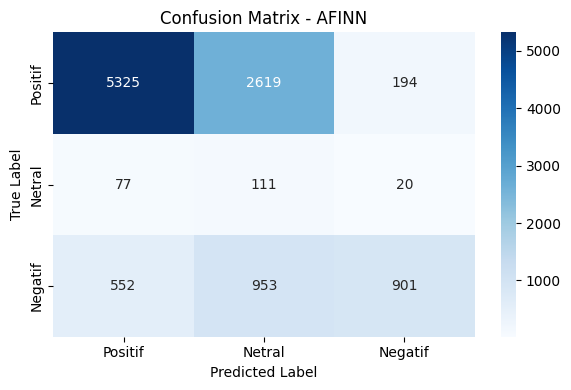


--- Evaluasi untuk Metode: SentiWordNet ---
Akurasi: 0.5765
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Positif       0.83      0.62      0.71      8138
      Netral       0.02      0.25      0.04       208
     Negatif       0.51      0.45      0.48      2406

    accuracy                           0.58     10752
   macro avg       0.45      0.44      0.41     10752
weighted avg       0.74      0.58      0.65     10752



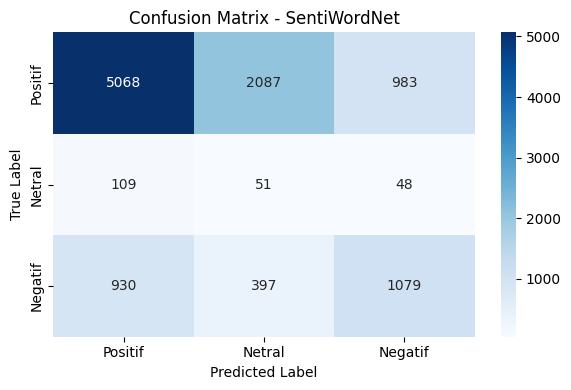


--- Evaluasi untuk Metode: SenticNet ---
Akurasi: 0.6074
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Positif       0.80      0.72      0.76      8138
      Netral       0.04      0.24      0.06       208
     Negatif       0.30      0.25      0.27      2406

    accuracy                           0.61     10752
   macro avg       0.38      0.40      0.36     10752
weighted avg       0.67      0.61      0.64     10752



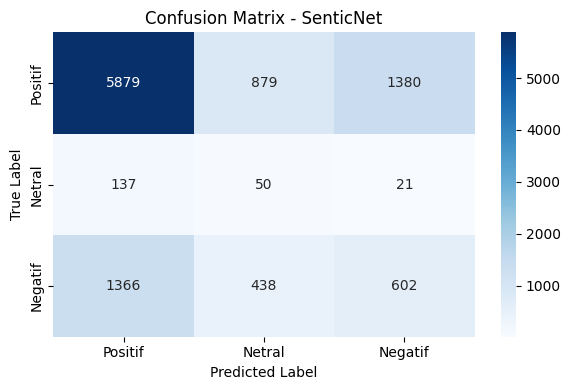


--- Evaluasi untuk Metode: TextBlob ---
Akurasi: 0.6847
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Positif       0.92      0.79      0.85      8138
      Netral       0.04      0.53      0.07       208
     Negatif       0.88      0.34      0.49      2406

    accuracy                           0.68     10752
   macro avg       0.61      0.55      0.47     10752
weighted avg       0.89      0.68      0.75     10752



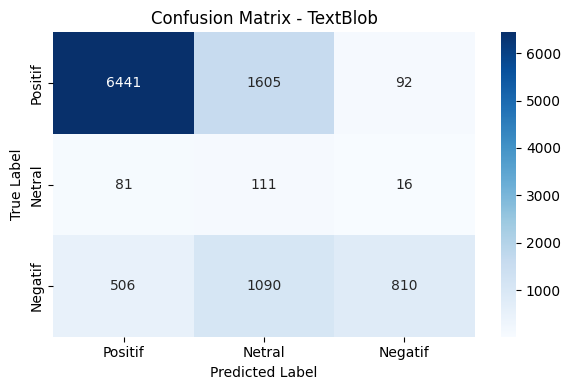



--- Tabel Perbandingan Kinerja Metode ---
         Method  Accuracy  Positif_Precision  Positif_Recall  Positif_F1-Score  Positif_Support  Netral_Precision  Netral_Recall  Netral_F1-Score  Netral_Support  Negatif_Precision  Negatif_Recall  Negatif_F1-Score  Negatif_Support  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1-Score  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1-Score
0         AFINN  0.589379           0.894357        0.654338          0.755748           8138.0          0.030138       0.533654         0.057055           208.0           0.808072        0.374480          0.511786           2406.0             0.577522          0.520824            0.441530                0.858330             0.589379               0.687640
1  SentiWordNet  0.576451           0.829867        0.622757          0.711548           8138.0          0.020118       0.245192         0.037186           208.0           0.511374        0.448462          0.477857           2406.0       

In [10]:
# --- Blok 4: Evaluasi dan Visualisasi ---
print("[FASE 4] Melakukan evaluasi dan visualisasi...")
start_fase4_time = time.time()

ground_truth_column = 'Sentimen Akhir' # Kolom sentimen manual Anda
evaluation_results = [] # List untuk menyimpan hasil evaluasi

# Fungsi evaluate_sentiments_detailed yang dimodifikasi untuk mengembalikan metrik
def evaluate_sentiments_detailed(y_true, y_pred, method_name, labels_order=["Positif", "Netral", "Negatif"]):
    if len(y_true) == 0 or len(y_pred) == 0 or len(y_true) != len(y_pred):
        print(f"[PERINGATAN] Data tidak valid untuk evaluasi {method_name}. Panjang y_true: {len(y_true)}, y_pred: {len(y_pred)}")
        return None

    valid_indices = y_true.notna() & y_pred.notna()
    y_true_cleaned = y_true[valid_indices]
    y_pred_cleaned = y_pred[valid_indices]

    if len(y_true_cleaned) == 0:
        print(f"[PERINGATAN] Tidak ada data valid setelah membersihkan NaN untuk evaluasi {method_name}.")
        return None

    accuracy = accuracy_score(y_true_cleaned, y_pred_cleaned)
    unique_labels_data = sorted(list(set(y_true_cleaned.unique()) | set(y_pred_cleaned.unique())))
    current_labels_order = [l for l in labels_order if l in unique_labels_data]
    if not current_labels_order: current_labels_order = unique_labels_data

    report_dict = classification_report(y_true_cleaned, y_pred_cleaned, labels=current_labels_order, zero_division=0, output_dict=True)
    cm = confusion_matrix(y_true_cleaned, y_pred_cleaned, labels=current_labels_order)

    print(f"\n--- Evaluasi untuk Metode: {method_name} ---")
    print(f"Akurasi: {accuracy:.4f}")
    print("Laporan Klasifikasi:")
    # Untuk tampilan di konsol, kita bisa print report string
    print(classification_report(y_true_cleaned, y_pred_cleaned, labels=current_labels_order, zero_division=0))
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=current_labels_order, 
                yticklabels=current_labels_order)
    plt.title(f'Confusion Matrix - {method_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    # Kumpulkan metrik untuk tabel perbandingan
    metrics = {'Method': method_name, 'Accuracy': accuracy}
    for label in current_labels_order:
        if label in report_dict:
            metrics[f'{label}_Precision'] = report_dict[label]['precision']
            metrics[f'{label}_Recall'] = report_dict[label]['recall']
            metrics[f'{label}_F1-Score'] = report_dict[label]['f1-score']
            metrics[f'{label}_Support'] = report_dict[label]['support']
        else: # Jika label tidak ada di prediksi sama sekali
            metrics[f'{label}_Precision'] = 0
            metrics[f'{label}_Recall'] = 0
            metrics[f'{label}_F1-Score'] = 0
            metrics[f'{label}_Support'] = 0 # Atau ambil dari y_true.value_counts()
            
    if 'macro avg' in report_dict:
        metrics['Macro_Avg_Precision'] = report_dict['macro avg']['precision']
        metrics['Macro_Avg_Recall'] = report_dict['macro avg']['recall']
        metrics['Macro_Avg_F1-Score'] = report_dict['macro avg']['f1-score']
    if 'weighted avg' in report_dict:
        metrics['Weighted_Avg_Precision'] = report_dict['weighted avg']['precision']
        metrics['Weighted_Avg_Recall'] = report_dict['weighted avg']['recall']
        metrics['Weighted_Avg_F1-Score'] = report_dict['weighted avg']['f1-score']
        
    return metrics


if ground_truth_column in df.columns:
    print(f"\n[INFO] Melakukan evaluasi berdasarkan kolom '{ground_truth_column}'...")
    df_eval = df.copy()
    df_eval.dropna(subset=[ground_truth_column], inplace=True)
    df_eval.reset_index(drop=True, inplace=True)

    if not df_eval.empty:
        # Pastikan kolom label ada sebelum evaluasi
        if 'afinn_label' in df_eval.columns:
            metrics_afinn = evaluate_sentiments_detailed(df_eval[ground_truth_column], df_eval['afinn_label'], "AFINN")
            if metrics_afinn: evaluation_results.append(metrics_afinn)
        else: print("[PERINGATAN] Kolom 'afinn_label' tidak ditemukan untuk evaluasi.")

        if 'swn_label' in df_eval.columns:
            metrics_swn = evaluate_sentiments_detailed(df_eval[ground_truth_column], df_eval['swn_label'], "SentiWordNet")
            if metrics_swn: evaluation_results.append(metrics_swn)
        else: print("[PERINGATAN] Kolom 'swn_label' tidak ditemukan untuk evaluasi.")

        if 'senticnet_label' in df_eval.columns:
            metrics_senticnet = evaluate_sentiments_detailed(df_eval[ground_truth_column], df_eval['senticnet_label'], "SenticNet")
            if metrics_senticnet: evaluation_results.append(metrics_senticnet)
        else: print("[PERINGATAN] Kolom 'senticnet_label' tidak ditemukan untuk evaluasi.")

        if 'textblob_label' in df_eval.columns:
            metrics_textblob = evaluate_sentiments_detailed(df_eval[ground_truth_column], df_eval['textblob_label'], "TextBlob")
            if metrics_textblob: evaluation_results.append(metrics_textblob)
        else: print("[PERINGATAN] Kolom 'textblob_label' tidak ditemukan untuk evaluasi.")
        
        # Membuat tabel perbandingan
        if evaluation_results:
            df_comparison = pd.DataFrame(evaluation_results)
            # Atur urutan kolom agar lebih mudah dibaca
            ordered_columns = ['Method', 'Accuracy']
            labels_for_order = ["Positif", "Netral", "Negatif"] # Sesuai urutan yang diinginkan
            
            for label in labels_for_order:
                if f'{label}_Precision' in df_comparison.columns: # Cek jika kolom ada
                    ordered_columns.extend([f'{label}_Precision', f'{label}_Recall', f'{label}_F1-Score', f'{label}_Support'])
            
            # Tambahkan kolom rata-rata jika ada
            avg_cols_to_check = ['Macro_Avg_Precision', 'Macro_Avg_Recall', 'Macro_Avg_F1-Score', 
                                 'Weighted_Avg_Precision', 'Weighted_Avg_Recall', 'Weighted_Avg_F1-Score']
            for col in avg_cols_to_check:
                if col in df_comparison.columns:
                    ordered_columns.append(col)
            
            # Filter ordered_columns agar hanya berisi kolom yang benar-benar ada di df_comparison
            final_ordered_columns = [col for col in ordered_columns if col in df_comparison.columns]

            df_comparison = df_comparison[final_ordered_columns]
            
            print("\n\n--- Tabel Perbandingan Kinerja Metode ---")
            print(df_comparison.to_string()) # .to_string() untuk tampilan yang lebih baik di konsol
            
            # Simpan tabel perbandingan ke file CSV terpisah
            try:
                comparison_csv_path = 'Data_Perbandingan_Metode_Sentiment.csv'
                df_comparison.to_csv(comparison_csv_path, index=False, encoding='utf-8-sig')
                print(f"\n[INFO] Tabel perbandingan disimpan ke: {comparison_csv_path}")
            except Exception as e:
                print(f"[ERROR] Gagal menyimpan tabel perbandingan: {e}")
        else:
            print("[PERINGATAN] Tidak ada hasil evaluasi yang valid untuk membuat tabel perbandingan.")

    else:
        print(f"[PERINGATAN] Tidak ada data ground truth yang valid di kolom '{ground_truth_column}' untuk evaluasi.")
else:
    print(f"[INFO] Kolom ground truth '{ground_truth_column}' tidak ditemukan. Evaluasi dilewati.")

end_fase4_time = time.time()
print(f"[FASE 4] Evaluasi dan visualisasi selesai dalam {end_fase4_time - start_fase4_time:.2f} detik.")
print("-" * 50)

In [11]:
# --- Blok 5: Penyimpanan Hasil Akhir DataFrame Utama ---
print("[FASE 5] Menyimpan hasil akhir DataFrame utama...")

output_csv_path_main = 'Data_Hasil_Sentiment_Dictionaries_Lengkap.csv' # Ganti nama agar beda dengan tabel perbandingan
try:
    df.to_csv(output_csv_path_main, index=False, encoding='utf-8-sig')
    print(f"\n[INFO] Hasil lengkap (termasuk skor mentah) disimpan ke: {output_csv_path_main}")
except Exception as e:
    print(f"[ERROR] Gagal menyimpan file CSV utama: {e}")

print("--- Proses Selesai ---")

[FASE 5] Menyimpan hasil akhir DataFrame utama...

[INFO] Hasil lengkap (termasuk skor mentah) disimpan ke: Data_Hasil_Sentiment_Dictionaries_Lengkap.csv
--- Proses Selesai ---


In [12]:
# --- Blok 6: Persiapan Data untuk Model Machine Learning (dengan N-gram Dinamis) ---
import time
print("[FASE ML - PERSIAPAN] Fungsi persiapan data untuk model ML dengan N-gram dinamis...")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Pastikan DataFrame 'df' dari fase sebelumnya tersedia
if 'df' not in globals():
    print("[ERROR] DataFrame 'df' tidak ditemukan. Pastikan fase sebelumnya sudah dijalankan.")
    exit()

text_column_for_ml = 'processed_text'
target_column_for_ml = 'Sentimen Akhir'

if text_column_for_ml not in df.columns or target_column_for_ml not in df.columns:
    print(f"[ERROR] Kolom '{text_column_for_ml}' atau '{target_column_for_ml}' tidak ditemukan di DataFrame.")
    exit()

# Fungsi untuk mempersiapkan data ML dengan ngram_range tertentu
def prepare_ml_data_with_ngrams(df_input, ngram_range_config):
    print(f"\n--- Mempersiapkan data dengan ngram_range: {ngram_range_config} ---")
    start_prep_time = time.time()

    df_ml_prep = df_input[[text_column_for_ml, target_column_for_ml]].copy()
    df_ml_prep.dropna(subset=[text_column_for_ml, target_column_for_ml], inplace=True)
    df_ml_prep = df_ml_prep[df_ml_prep[text_column_for_ml].str.strip() != '']

    if df_ml_prep.empty:
        print("[ERROR] Tidak ada data yang valid untuk diproses setelah menghapus NaN/teks kosong.")
        return None, None, None, None, None, None # Kembalikan None jika tidak ada data

    X_text = df_ml_prep[text_column_for_ml]
    y_labels_prep = df_ml_prep[target_column_for_ml]

    print(f"Jumlah data valid untuk ML (ngram {ngram_range_config}): {len(df_ml_prep)}")

    tfidf_vectorizer_ngram = TfidfVectorizer(
        max_features=5000,
        ngram_range=ngram_range_config, # Gunakan konfigurasi ngram yang diberikan
        min_df=2,
        max_df=0.95
    )

    print(f"[INFO] Melakukan fit dan transform dengan TF-IDF (ngram {ngram_range_config})...")
    X_tfidf_ngram = tfidf_vectorizer_ngram.fit_transform(X_text)
    print(f"Dimensi matriks TF-IDF (ngram {ngram_range_config}): {X_tfidf_ngram.shape}")
    
    # Penting: Simpan vectorizer yang sudah di-fit untuk digunakan pada data baru jika diperlukan nanti
    # Untuk evaluasi ini, kita hanya fokus pada train/test split dari data yang sama

    label_encoder_prep = LabelEncoder() # Buat instance baru agar tidak ada state dari iterasi sebelumnya
    y_encoded_prep = label_encoder_prep.fit_transform(y_labels_prep)
    
    # Pastikan label_mapping dan class_names_ml menggunakan encoder yang baru di-fit ini
    current_label_mapping = {index: label for index, label in enumerate(label_encoder_prep.classes_)}
    current_class_names = list(label_encoder_prep.classes_)
    print(f"Label mapping (ngram {ngram_range_config}): {current_label_mapping}")


    min_samples_per_class = 2
    can_stratify_prep = len(y_labels_prep.unique()) > 1 and y_labels_prep.value_counts().min() >= min_samples_per_class

    if can_stratify_prep:
        X_train_ngram, X_test_ngram, y_train_ngram, y_test_ngram = train_test_split(
            X_tfidf_ngram, y_encoded_prep, test_size=0.2, random_state=42, stratify=y_encoded_prep
        )
    else:
        print(f"[PERINGATAN] Tidak dapat stratifikasi untuk ngram {ngram_range_config}. Membagi tanpa stratifikasi.")
        X_train_ngram, X_test_ngram, y_train_ngram, y_test_ngram = train_test_split(
            X_tfidf_ngram, y_encoded_prep, test_size=0.2, random_state=42
        )
    
    end_prep_time = time.time()
    print(f"Persiapan data (ngram {ngram_range_config}) selesai dalam {end_prep_time - start_prep_time:.2f} detik.")
    
    return X_train_ngram, X_test_ngram, y_train_ngram, y_test_ngram, label_encoder_prep, current_class_names, tfidf_vectorizer_ngram

print("[FASE ML - PERSIAPAN] Fungsi persiapan data telah didefinisikan.")
print("-" * 50)

[FASE ML - PERSIAPAN] Fungsi persiapan data untuk model ML dengan N-gram dinamis...
[FASE ML - PERSIAPAN] Fungsi persiapan data telah didefinisikan.
--------------------------------------------------


[FASE ML - EKSPERIMEN N-GRAM SPESIFIK & EVALUASI ML]
Memulai pelatihan dan evaluasi model ML dengan N-gram tunggal (1-gram, 2-gram, 3-gram, 4-gram)...
[ERROR] Variabel/fungsi prasyarat (df, prepare_ml_data_with_ngrams, evaluate_sentiments_detailed, target_column_for_ml, label_encoder) tidak ditemukan.
         Pastikan Blok 0, 1, 4, dan 6 sudah dijalankan dengan benar.
[INFO] Akan menguji model ML dengan konfigurasi N-gram tunggal spesifik berikut: [(1, 1), (2, 2), (3, 3), (4, 4)]


==================== MEMPROSES N-GRAM: (1, 1) UNTUK SEMUA MODEL ML ====================

--- Mempersiapkan data dengan ngram_range: (1, 1) ---
Jumlah data valid untuk ML (ngram (1, 1)): 10752
[INFO] Melakukan fit dan transform dengan TF-IDF (ngram (1, 1))...
Dimensi matriks TF-IDF (ngram (1, 1)): (10752, 2004)
Label mapping (ngram (1, 1)): {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
Persiapan data (ngram (1, 1)) selesai dalam 0.07 detik.

--- Melatih dan Mengevaluasi: ML - Logistic Regression (Ngram: (1, 1)) 

/home/xerces/anaconda3/envs/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/xerces/anaconda3/envs/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


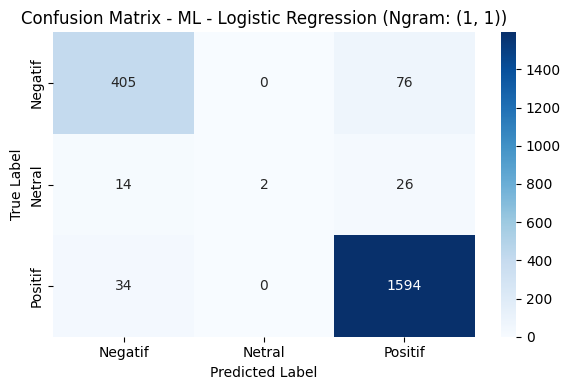


--- Melatih dan Mengevaluasi: ML - MLP Neural Network (Ngram: (1, 1)) ---
Pelatihan selesai dalam 7.48 detik.

--- Evaluasi untuk Metode: ML - MLP Neural Network (Ngram: (1, 1)) ---
Akurasi: 0.9307
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.88      0.85      0.87       481
      Netral       0.45      0.24      0.31        42
     Positif       0.95      0.97      0.96      1628

    accuracy                           0.93      2151
   macro avg       0.76      0.69      0.71      2151
weighted avg       0.93      0.93      0.93      2151



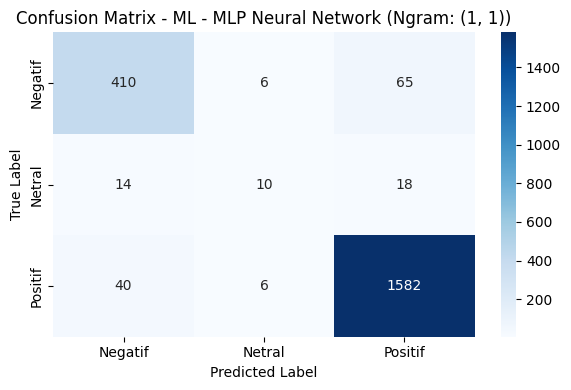


--- Melatih dan Mengevaluasi: ML - Naive Bayes (Multinomial) (Ngram: (1, 1)) ---
Pelatihan selesai dalam 0.00 detik.

--- Evaluasi untuk Metode: ML - Naive Bayes (Multinomial) (Ngram: (1, 1)) ---
Akurasi: 0.9354
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.87      0.88      0.88       481
      Netral       1.00      0.02      0.05        42
     Positif       0.95      0.97      0.96      1628

    accuracy                           0.94      2151
   macro avg       0.94      0.63      0.63      2151
weighted avg       0.94      0.94      0.93      2151



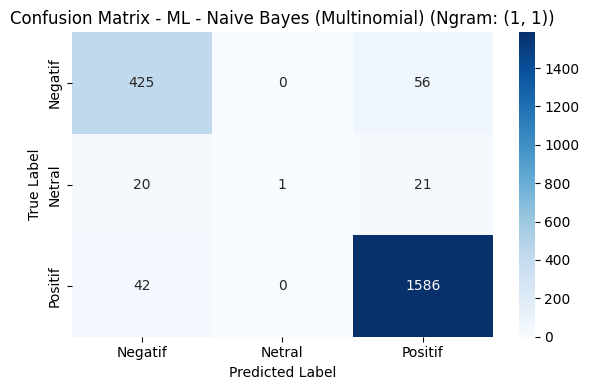



==================== MEMPROSES N-GRAM: (2, 2) UNTUK SEMUA MODEL ML ====================

--- Mempersiapkan data dengan ngram_range: (2, 2) ---
Jumlah data valid untuk ML (ngram (2, 2)): 10752
[INFO] Melakukan fit dan transform dengan TF-IDF (ngram (2, 2))...
Dimensi matriks TF-IDF (ngram (2, 2)): (10752, 5000)
Label mapping (ngram (2, 2)): {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
Persiapan data (ngram (2, 2)) selesai dalam 0.11 detik.

--- Melatih dan Mengevaluasi: ML - Logistic Regression (Ngram: (2, 2)) ---
Pelatihan selesai dalam 0.03 detik.

--- Evaluasi untuk Metode: ML - Logistic Regression (Ngram: (2, 2)) ---
Akurasi: 0.8791
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.95      0.57      0.71       481
      Netral       0.00      0.00      0.00        42
     Positif       0.87      0.99      0.93      1628

    accuracy                           0.88      2151
   macro avg       0.61      0.52      0.55      2151
weighted a

/home/xerces/anaconda3/envs/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/xerces/anaconda3/envs/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


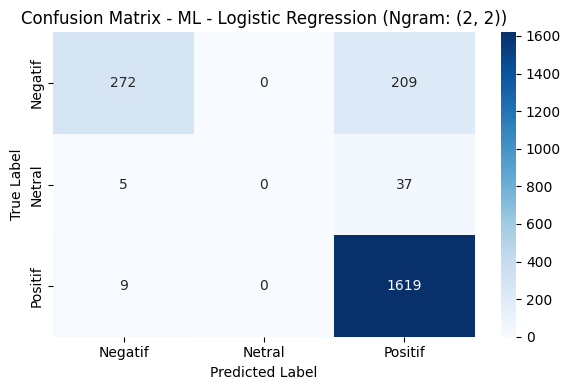


--- Melatih dan Mengevaluasi: ML - MLP Neural Network (Ngram: (2, 2)) ---
Pelatihan selesai dalam 9.80 detik.

--- Evaluasi untuk Metode: ML - MLP Neural Network (Ngram: (2, 2)) ---
Akurasi: 0.9126
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.92      0.74      0.82       481
      Netral       1.00      0.02      0.05        42
     Positif       0.91      0.99      0.95      1628

    accuracy                           0.91      2151
   macro avg       0.94      0.58      0.60      2151
weighted avg       0.91      0.91      0.90      2151



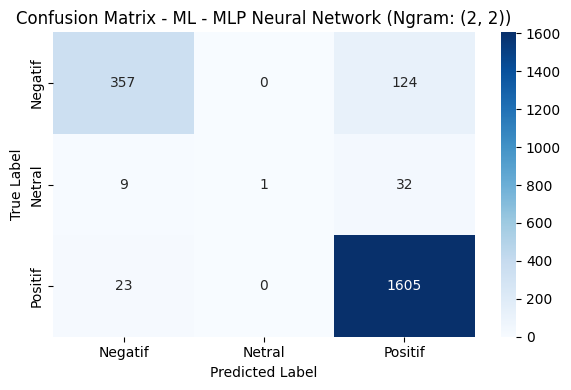


--- Melatih dan Mengevaluasi: ML - Naive Bayes (Multinomial) (Ngram: (2, 2)) ---
Pelatihan selesai dalam 0.00 detik.

--- Evaluasi untuk Metode: ML - Naive Bayes (Multinomial) (Ngram: (2, 2)) ---
Akurasi: 0.9089
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.93      0.72      0.81       481
      Netral       0.00      0.00      0.00        42
     Positif       0.91      0.99      0.95      1628

    accuracy                           0.91      2151
   macro avg       0.61      0.57      0.58      2151
weighted avg       0.89      0.91      0.90      2151



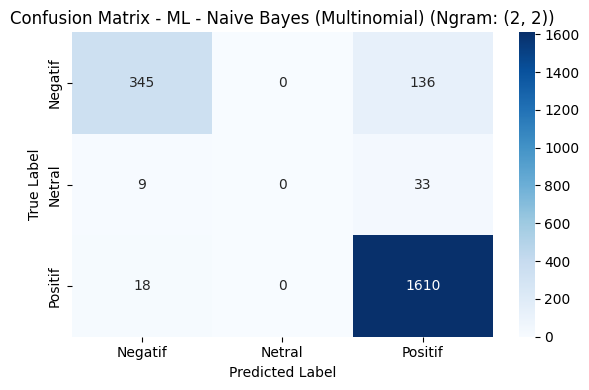



==================== MEMPROSES N-GRAM: (3, 3) UNTUK SEMUA MODEL ML ====================

--- Mempersiapkan data dengan ngram_range: (3, 3) ---
Jumlah data valid untuk ML (ngram (3, 3)): 10752
[INFO] Melakukan fit dan transform dengan TF-IDF (ngram (3, 3))...
Dimensi matriks TF-IDF (ngram (3, 3)): (10752, 5000)
Label mapping (ngram (3, 3)): {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
Persiapan data (ngram (3, 3)) selesai dalam 0.14 detik.

--- Melatih dan Mengevaluasi: ML - Logistic Regression (Ngram: (3, 3)) ---
Pelatihan selesai dalam 0.02 detik.

--- Evaluasi untuk Metode: ML - Logistic Regression (Ngram: (3, 3)) ---
Akurasi: 0.8071
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.93      0.23      0.37       481
      Netral       0.00      0.00      0.00        42
     Positif       0.80      1.00      0.89      1628

    accuracy                           0.81      2151
   macro avg       0.58      0.41      0.42      2151
weighted a

/home/xerces/anaconda3/envs/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/xerces/anaconda3/envs/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


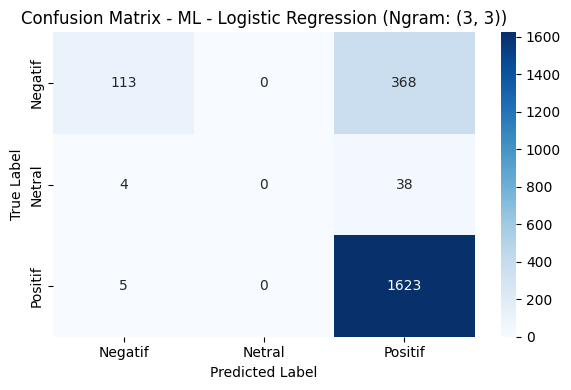


--- Melatih dan Mengevaluasi: ML - MLP Neural Network (Ngram: (3, 3)) ---
Pelatihan selesai dalam 13.92 detik.

--- Evaluasi untuk Metode: ML - MLP Neural Network (Ngram: (3, 3)) ---
Akurasi: 0.8810
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.88      0.61      0.72       481
      Netral       0.40      0.05      0.09        42
     Positif       0.88      0.98      0.93      1628

    accuracy                           0.88      2151
   macro avg       0.72      0.55      0.58      2151
weighted avg       0.87      0.88      0.87      2151



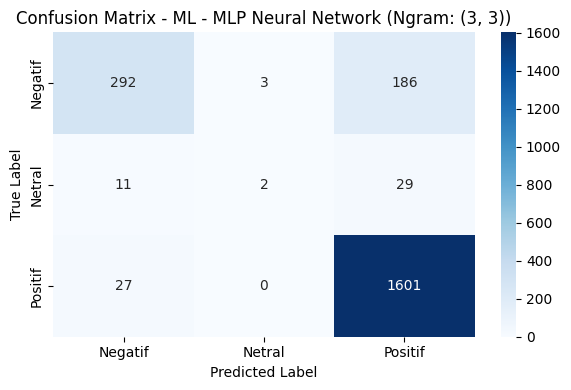


--- Melatih dan Mengevaluasi: ML - Naive Bayes (Multinomial) (Ngram: (3, 3)) ---
Pelatihan selesai dalam 0.00 detik.

--- Evaluasi untuk Metode: ML - Naive Bayes (Multinomial) (Ngram: (3, 3)) ---
Akurasi: 0.8405
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.94      0.39      0.55       481
      Netral       0.00      0.00      0.00        42
     Positif       0.83      1.00      0.91      1628

    accuracy                           0.84      2151
   macro avg       0.59      0.46      0.49      2151
weighted avg       0.84      0.84      0.81      2151



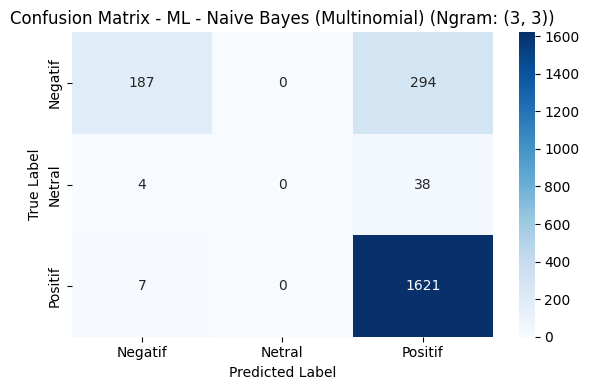



==================== MEMPROSES N-GRAM: (4, 4) UNTUK SEMUA MODEL ML ====================

--- Mempersiapkan data dengan ngram_range: (4, 4) ---
Jumlah data valid untuk ML (ngram (4, 4)): 10752
[INFO] Melakukan fit dan transform dengan TF-IDF (ngram (4, 4))...
Dimensi matriks TF-IDF (ngram (4, 4)): (10752, 2371)
Label mapping (ngram (4, 4)): {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
Persiapan data (ngram (4, 4)) selesai dalam 0.14 detik.

--- Melatih dan Mengevaluasi: ML - Logistic Regression (Ngram: (4, 4)) ---
Pelatihan selesai dalam 0.01 detik.

--- Evaluasi untuk Metode: ML - Logistic Regression (Ngram: (4, 4)) ---
Akurasi: 0.7773
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.94      0.10      0.18       481
      Netral       0.00      0.00      0.00        42
     Positif       0.77      1.00      0.87      1628

    accuracy                           0.78      2151
   macro avg       0.57      0.37      0.35      2151
weighted a

/home/xerces/anaconda3/envs/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/xerces/anaconda3/envs/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


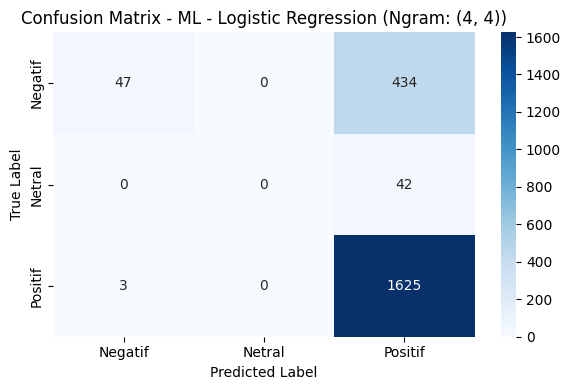


--- Melatih dan Mengevaluasi: ML - MLP Neural Network (Ngram: (4, 4)) ---
Pelatihan selesai dalam 6.94 detik.

--- Evaluasi untuk Metode: ML - MLP Neural Network (Ngram: (4, 4)) ---
Akurasi: 0.8280
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.86      0.37      0.51       481
      Netral       1.00      0.05      0.09        42
     Positif       0.82      0.98      0.90      1628

    accuracy                           0.83      2151
   macro avg       0.89      0.47      0.50      2151
weighted avg       0.84      0.83      0.80      2151



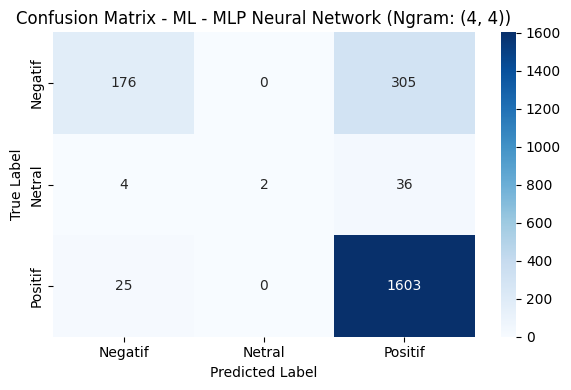


--- Melatih dan Mengevaluasi: ML - Naive Bayes (Multinomial) (Ngram: (4, 4)) ---
Pelatihan selesai dalam 0.00 detik.

--- Evaluasi untuk Metode: ML - Naive Bayes (Multinomial) (Ngram: (4, 4)) ---
Akurasi: 0.7894
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.95      0.15      0.26       481
      Netral       0.00      0.00      0.00        42
     Positif       0.78      1.00      0.88      1628

    accuracy                           0.79      2151
   macro avg       0.58      0.38      0.38      2151
weighted avg       0.81      0.79      0.72      2151



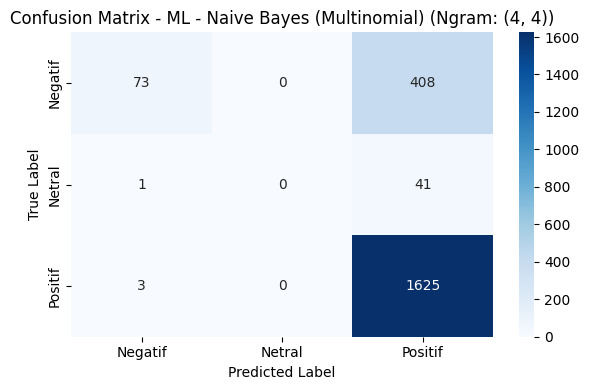


[FASE ML - EKSPERIMEN N-GRAM SPESIFIK & EVALUASI ML] Selesai dalam 40.60 detik.
--------------------------------------------------
[PERINGATAN] 'evaluation_results_kamus' tidak ditemukan atau bukan list. Hasil kamus tidak akan ada di tabel perbandingan akhir.
[INFO] 12 hasil dari model ML (dengan N-gram) dari eksekusi ini digabungkan.


--- Tabel Perbandingan Kinerja: Metode Kamus vs. Model ML (dengan N-gram Tunggal Spesifik) ---
Menampilkan DataFrame perbandingan (jika di Jupyter/IPython):


,Method,Accuracy,Negatif_Precision,Negatif_Recall,Negatif_F1-Score,Negatif_Support,Netral_Precision,Netral_Recall,Netral_F1-Score,Netral_Support,Positif_Precision,Positif_Recall,Positif_F1-Score,Positif_Support,Macro_Avg_Precision,Macro_Avg_Recall,Macro_Avg_F1-Score,Weighted_Avg_Precision,Weighted_Avg_Recall,Weighted_Avg_F1-Score
0,"ML - Logistic Regression (Ngram: (1, 1))",0.930265,0.894040,0.841996,0.867238,481.0,1.000000,0.047619,0.090909,42.0,0.939858,0.979115,0.959085,1628.0,0.944633,0.622910,0.639077,0.930787,0.930265,0.921595
1,"ML - MLP Neural Network (Ngram: (1, 1))",0.930730,0.883621,0.852391,0.867725,481.0,0.454545,0.238095,0.312500,42.0,0.950150,0.971744,0.960826,1628.0,0.762772,0.687410,0.713684,0.925596,0.930730,0.927348
2,"ML - Naive Bayes (Multinomial) (Ngram: (1, 1))",0.935379,0.872690,0.883576,0.878099,481.0,1.000000,0.023810,0.046512,42.0,0.953698,0.974201,0.963841,1628.0,0.942129,0.627196,0.629484,0.936487,0.935379,0.926756
3,"ML - Logistic Regression (Ngram: (2, 2))",0.879126,0.951049,0.565489,0.709257,481.0,0.000000,0.000000,0.000000,42.0,0.868097,0.994472,0.926997,1628.0,0.606382,0.519987,0.545418,0.869696,0.879126,0.860206
4,"ML - MLP Neural Network (Ngram: (2, 2))",0.912599,0.917738,0.742204,0.820690,481.0,1.000000,0.023810,0.046512,42.0,0.911414,0.985872,0.947182,1628.0,0.943051,0.583962,0.604794,0.914558,0.912599,0.901310
5,"ML - Naive Bayes (Multinomial) (Ngram: (2, 2))",0.908880,0.927419,0.717256,0.808910,481.0,0.000000,0.000000,0.000000,42.0,0.905003,0.988943,0.945113,1628.0,0.610807,0.568733,0.584674,0.892345,0.908880,0.896202
6,"ML - Logistic Regression (Ngram: (3, 3))",0.807066,0.926230,0.234927,0.374793,481.0,0.000000,0.000000,0.000000,42.0,0.799901,0.996929,0.887613,1628.0,0.575377,0.410619,0.420802,0.812532,0.807066,0.755606
7,"ML - MLP Neural Network (Ngram: (3, 3))",0.880986,0.884848,0.607069,0.720099,481.0,0.400000,0.047619,0.085106,42.0,0.881608,0.983415,0.929733,1628.0,0.722152,0.546034,0.578313,0.872929,0.880986,0.866363
8,"ML - Naive Bayes (Multinomial) (Ngram: (3, 3))",0.840539,0.944444,0.388773,0.550810,481.0,0.000000,0.000000,0.000000,42.0,0.830005,0.995700,0.905334,1628.0,0.591483,0.461491,0.485381,0.839389,0.840539,0.808379
9,"ML - Logistic Regression (Ngram: (4, 4))",0.777313,0.940000,0.097713,0.177024,481.0,0.000000,0.000000,0.000000,42.0,0.773441,0.998157,0.871547,1628.0,0.571147,0.365290,0.349524,0.795585,0.777313,0.699223



[INFO] Tabel perbandingan (Kamus vs ML N-gram spesifik) disimpan ke: Data_Perbandingan_Kamus_vs_ML_Ngram_Spesifik_Final.csv


TOP 5 METODE BERDASARKAN METRIK EVALUASI (dari tabel gabungan terakhir)

--- Top 5 Metode Berdasarkan Accuracy ---


,Method,Accuracy,Weighted_Avg_F1-Score
2,"ML - Naive Bayes (Multinomial) (Ngram: (1, 1))",0.935379,0.926756
1,"ML - MLP Neural Network (Ngram: (1, 1))",0.930730,0.927348
0,"ML - Logistic Regression (Ngram: (1, 1))",0.930265,0.921595
4,"ML - MLP Neural Network (Ngram: (2, 2))",0.912599,0.901310
5,"ML - Naive Bayes (Multinomial) (Ngram: (2, 2))",0.908880,0.896202



--- Top 5 Metode Berdasarkan Weighted_Avg_F1-Score ---


,Method,Weighted_Avg_F1-Score,Accuracy
1,"ML - MLP Neural Network (Ngram: (1, 1))",0.927348,0.930730
2,"ML - Naive Bayes (Multinomial) (Ngram: (1, 1))",0.926756,0.935379
0,"ML - Logistic Regression (Ngram: (1, 1))",0.921595,0.930265
4,"ML - MLP Neural Network (Ngram: (2, 2))",0.901310,0.912599
5,"ML - Naive Bayes (Multinomial) (Ngram: (2, 2))",0.896202,0.908880


--------------------------------------------------
--- Proses Selesai (Blok 7 - Eksperimen N-gram ML Spesifik dan Perbandingan Akhir dengan Kamus) ---


In [13]:
# --- Blok 7: Pelatihan Model ML (dengan N-gram Tunggal 1, 2, 3, 4) dan Perbandingan Akhir dengan Kamus ---
import time
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd # Pastikan pandas diimpor jika belum di sel ini

# List BARU KHUSUS untuk menyimpan hasil evaluasi model ML dari EKSEKUSI BLOK INI SAJA
evaluation_results_ml_this_run = [] 

print("[FASE ML - EKSPERIMEN N-GRAM SPESIFIK & EVALUASI ML]")
print("Memulai pelatihan dan evaluasi model ML dengan N-gram tunggal (1-gram, 2-gram, 3-gram, 4-gram)...")
start_fase_ml_specific_ngram_time = time.time()

# Pastikan variabel dan fungsi dari blok sebelumnya tersedia
if 'df' not in globals() or 'prepare_ml_data_with_ngrams' not in globals() or \
   'evaluate_sentiments_detailed' not in globals() or 'target_column_for_ml' not in globals() or \
   'label_encoder' not in globals():
    print("[ERROR] Variabel/fungsi prasyarat (df, prepare_ml_data_with_ngrams, evaluate_sentiments_detailed, target_column_for_ml, label_encoder) tidak ditemukan.")
    print("         Pastikan Blok 0, 1, 4, dan 6 sudah dijalankan dengan benar.")
    # exit() # Hentikan eksekusi jika prasyarat tidak terpenuhi

# Jika df tidak ada, kita tidak bisa melanjutkan.
if 'df' not in globals():
    print("[FATAL ERROR] DataFrame 'df' tidak tersedia. Proses dihentikan.")
    # Anda bisa menambahkan 'exit()' di sini jika ini adalah skrip, 
    # atau biarkan error terjadi jika di notebook agar jelas.
    raise NameError("DataFrame 'df' is not defined. Please run previous blocks.")


# --- KONFIGURASI N-GRAM YANG AKAN DIUJI UNTUK ML ---
# Sesuai permintaan: hanya unigram, hanya bigram, hanya trigram, hanya fourgram
ngram_configurations_for_ml_comparison = [
    (1, 1),  # Hanya Unigrams
    (2, 2),  # Hanya Bigrams
    (3, 3),  # Hanya Trigrams
    (4, 4)   # Hanya Fourgrams
]
print(f"[INFO] Akan menguji model ML dengan konfigurasi N-gram tunggal spesifik berikut: {ngram_configurations_for_ml_comparison}")

models_to_train_final_comparison = {
    "Logistic Regression": LogisticRegression(solver='liblinear', multi_class='auto', random_state=42, max_iter=1000),
    "MLP Neural Network": MLPClassifier(hidden_layer_sizes=(64,), max_iter=200, activation='relu', solver='adam', random_state=42, early_stopping=True, n_iter_no_change=10, learning_rate_init=0.001),
    "Naive Bayes (Multinomial)": MultinomialNB()
}

# Loop melalui setiap konfigurasi N-gram spesifik
for ngram_config_ml in ngram_configurations_for_ml_comparison:
    print(f"\n\n{'='*20} MEMPROSES N-GRAM: {ngram_config_ml} UNTUK SEMUA MODEL ML {'='*20}")
    
    # 1. Persiapkan data dengan konfigurasi N-gram saat ini
    # Pastikan prepare_ml_data_with_ngrams sudah didefinisikan (dari Blok 6)
    if 'prepare_ml_data_with_ngrams' not in globals():
        print("[FATAL ERROR] Fungsi 'prepare_ml_data_with_ngrams' tidak ditemukan. Jalankan Blok 6.")
        raise NameError("Function 'prepare_ml_data_with_ngrams' is not defined.")
        
    ml_data_package_current_ngram = prepare_ml_data_with_ngrams(df, ngram_config_ml)
    if ml_data_package_current_ngram[0] is None:
        print(f"[ERROR] Gagal mempersiapkan data untuk ngram {ngram_config_ml}. Melanjutkan.")
        continue

    X_train_ngram_iter, X_test_ngram_iter, y_train_ngram_iter, y_test_ngram_iter, \
    current_label_encoder_iter, current_class_names_iter, _ = ml_data_package_current_ngram

    # 2. Loop melalui setiap model ML untuk dilatih dan dievaluasi dengan fitur N-gram saat ini
    for model_name, model_prototype in models_to_train_final_comparison.items():
        method_identifier_ml_ngram = f"ML - {model_name} (Ngram: {ngram_config_ml})"
        print(f"\n--- Melatih dan Mengevaluasi: {method_identifier_ml_ngram} ---")
        
        current_model_instance_iter = model_prototype # Buat instance baru dari prototipe
        start_train_loop_iter = time.time()
        try:
            current_model_instance_iter.fit(X_train_ngram_iter, y_train_ngram_iter)
        except Exception as e:
            print(f"[ERROR] Gagal melatih {model_name} (Ngram: {ngram_config_ml}): {e}")
            continue # Lanjut ke model ML berikutnya
        print(f"Pelatihan selesai dalam {time.time() - start_train_loop_iter:.2f} detik.")

        # Prediksi pada data uji
        y_pred_ml_encoded_iter = current_model_instance_iter.predict(X_test_ngram_iter)
        y_pred_ml_labels_str_iter = current_label_encoder_iter.inverse_transform(y_pred_ml_encoded_iter)
        y_test_ml_labels_str_iter = current_label_encoder_iter.inverse_transform(y_test_ngram_iter) # Ground truth

        # Pastikan evaluate_sentiments_detailed sudah didefinisikan (dari Blok 4)
        if 'evaluate_sentiments_detailed' not in globals():
            print("[FATAL ERROR] Fungsi 'evaluate_sentiments_detailed' tidak ditemukan. Jalankan Blok 4.")
            raise NameError("Function 'evaluate_sentiments_detailed' is not defined.")

        metrics_for_ml_model_iter = evaluate_sentiments_detailed(
            pd.Series(y_test_ml_labels_str_iter),
            pd.Series(y_pred_ml_labels_str_iter),
            method_identifier_ml_ngram,
            labels_order=current_class_names_iter
        )
        if metrics_for_ml_model_iter:
            evaluation_results_ml_this_run.append(metrics_for_ml_model_iter)

end_fase_ml_specific_ngram_time = time.time()
print(f"\n[FASE ML - EKSPERIMEN N-GRAM SPESIFIK & EVALUASI ML] Selesai dalam {end_fase_ml_specific_ngram_time - start_fase_ml_specific_ngram_time:.2f} detik.")
print("-" * 50)

# --- Menggabungkan Hasil Kamus (dari Blok 4, jika ada) dengan Hasil ML (dari eksekusi Blok 7 ini) ---
# `evaluation_results_kamus` seharusnya sudah ada jika Blok 4 dijalankan.
# Kita buat list gabungan baru untuk tabel final.
final_combined_evaluation_results = []

if 'evaluation_results_kamus' in globals() and isinstance(evaluation_results_kamus, list):
    final_combined_evaluation_results.extend(evaluation_results_kamus)
    print(f"[INFO] {len(evaluation_results_kamus)} hasil dari metode kamus digabungkan.")
else:
    print("[PERINGATAN] 'evaluation_results_kamus' tidak ditemukan atau bukan list. Hasil kamus tidak akan ada di tabel perbandingan akhir.")

# Tambahkan hasil ML dari run saat ini
final_combined_evaluation_results.extend(evaluation_results_ml_this_run)
print(f"[INFO] {len(evaluation_results_ml_this_run)} hasil dari model ML (dengan N-gram) dari eksekusi ini digabungkan.")


# --- Tabel Perbandingan Akhir ---
if final_combined_evaluation_results:
    df_comparison_all_final = pd.DataFrame(final_combined_evaluation_results)
    
    # Hapus duplikat berdasarkan kolom 'Method' jika ada (misalnya, jika Blok 4 dijalankan ulang)
    # Ini akan menjaga hasil kamus dari eksekusi Blok 4 terakhir.
    # Hasil ML dari `evaluation_results_ml_this_run` selalu unik untuk run ini.
    df_comparison_all_final.drop_duplicates(subset=['Method'], keep='last', inplace=True)
    
    # Atur urutan kolom
    ordered_cols_all_final = ['Method', 'Accuracy']
    # Pastikan target_column_for_ml dan df ada untuk mendapatkan label
    if 'target_column_for_ml' in globals() and target_column_for_ml in df.columns:
         all_possible_labels_table = sorted(list(set(df[target_column_for_ml].dropna().unique())))
    else:
         all_possible_labels_table = ["Positif", "Netral", "Negatif"]
         print(f"[PERINGATAN] Kolom target atau df tidak ditemukan untuk urutan label tabel, menggunakan default.")
    
    for label in all_possible_labels_table:
        if f'{label}_Precision' in df_comparison_all_final.columns:
            ordered_cols_all_final.extend([f'{label}_Precision', f'{label}_Recall', f'{label}_F1-Score', f'{label}_Support'])
    
    avg_cols_to_check_all_table = ['Macro_Avg_Precision', 'Macro_Avg_Recall', 'Macro_Avg_F1-Score', 
                                   'Weighted_Avg_Precision', 'Weighted_Avg_Recall', 'Weighted_Avg_F1-Score']
    for col in avg_cols_to_check_all_table:
        if col in df_comparison_all_final.columns:
            ordered_cols_all_final.append(col)
    
    final_ordered_cols_for_table = [col for col in ordered_cols_all_final if col in df_comparison_all_final.columns]
    if final_ordered_cols_for_table:
        df_comparison_all_final = df_comparison_all_final.reindex(columns=final_ordered_cols_for_table)
    elif 'Method' in df_comparison_all_final.columns and 'Accuracy' in df_comparison_all_final.columns :
        df_comparison_all_final = df_comparison_all_final[['Method', 'Accuracy']]

    print("\n\n--- Tabel Perbandingan Kinerja: Metode Kamus vs. Model ML (dengan N-gram Tunggal Spesifik) ---")
    try:
        from IPython.display import display
        print("Menampilkan DataFrame perbandingan (jika di Jupyter/IPython):")
        display(df_comparison_all_final)
    except ImportError:
        print(df_comparison_all_final.to_string(na_rep='-')) # na_rep untuk mengisi NaN jika ada
    
    try:
        comparison_all_final_csv_path = 'Data_Perbandingan_Kamus_vs_ML_Ngram_Spesifik_Final.csv'
        df_comparison_all_final.to_csv(comparison_all_final_csv_path, index=False, encoding='utf-8-sig')
        print(f"\n[INFO] Tabel perbandingan (Kamus vs ML N-gram spesifik) disimpan ke: {comparison_all_final_csv_path}")
    except Exception as e:
        print(f"[ERROR] Gagal menyimpan tabel perbandingan: {e}")
else:
    print("[PERINGATAN] Tidak ada hasil evaluasi gabungan untuk membuat tabel perbandingan.")

# --- (Tambahan) Menampilkan 5 Metode Teratas dari tabel gabungan ---
if 'df_comparison_all_final' in globals() and not df_comparison_all_final.empty:
    print("\n\n" + "="*30)
    print("TOP 5 METODE BERDASARKAN METRIK EVALUASI (dari tabel gabungan terakhir)")
    print("="*30)

    sort_metric_accuracy = 'Accuracy'
    sort_metric_f1_weighted = 'Weighted_Avg_F1-Score'

    # Top 5 Berdasarkan Akurasi
    if sort_metric_accuracy in df_comparison_all_final.columns:
        df_top5_accuracy = df_comparison_all_final.sort_values(by=sort_metric_accuracy, ascending=False).head(5)
        print(f"\n--- Top 5 Metode Berdasarkan {sort_metric_accuracy} ---")
        cols_to_show_acc = ['Method', sort_metric_accuracy]
        if sort_metric_f1_weighted in df_top5_accuracy.columns: # Tampilkan juga F1 jika ada
             cols_to_show_acc.append(sort_metric_f1_weighted)
        try:
            from IPython.display import display
            display(df_top5_accuracy[cols_to_show_acc])
        except ImportError:
            print(df_top5_accuracy[cols_to_show_acc].to_string(index=False))
    else:
        print(f"[PERINGATAN] Kolom metrik '{sort_metric_accuracy}' tidak ditemukan untuk sorting.")

    # Top 5 Berdasarkan Weighted Average F1-Score
    if sort_metric_f1_weighted in df_comparison_all_final.columns:
        df_top5_f1_weighted = df_comparison_all_final.sort_values(by=sort_metric_f1_weighted, ascending=False).head(5)
        print(f"\n--- Top 5 Metode Berdasarkan {sort_metric_f1_weighted} ---")
        cols_to_show_f1 = ['Method', sort_metric_f1_weighted]
        if sort_metric_accuracy in df_top5_f1_weighted.columns and sort_metric_accuracy not in cols_to_show_f1:
            cols_to_show_f1.append(sort_metric_accuracy)
        try:
            from IPython.display import display
            display(df_top5_f1_weighted[cols_to_show_f1])
        except ImportError:
            print(df_top5_f1_weighted[cols_to_show_f1].to_string(index=False))
    else:
        print(f"[PERINGATAN] Kolom metrik '{sort_metric_f1_weighted}' tidak ditemukan untuk sorting.")
else:
    print("[PERINGATAN] 'df_comparison_all_final' tidak ditemukan atau kosong. Tidak dapat menampilkan Top 5 metode.")

print("-" * 50)
print("--- Proses Selesai (Blok 7 - Eksperimen N-gram ML Spesifik dan Perbandingan Akhir dengan Kamus) ---")